<a href="https://colab.research.google.com/github/Sanele098/AI/blob/main/AI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy

In [40]:
# General libraries
import pandas as pd 
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
#from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
#tf.set_random_seed(seed)

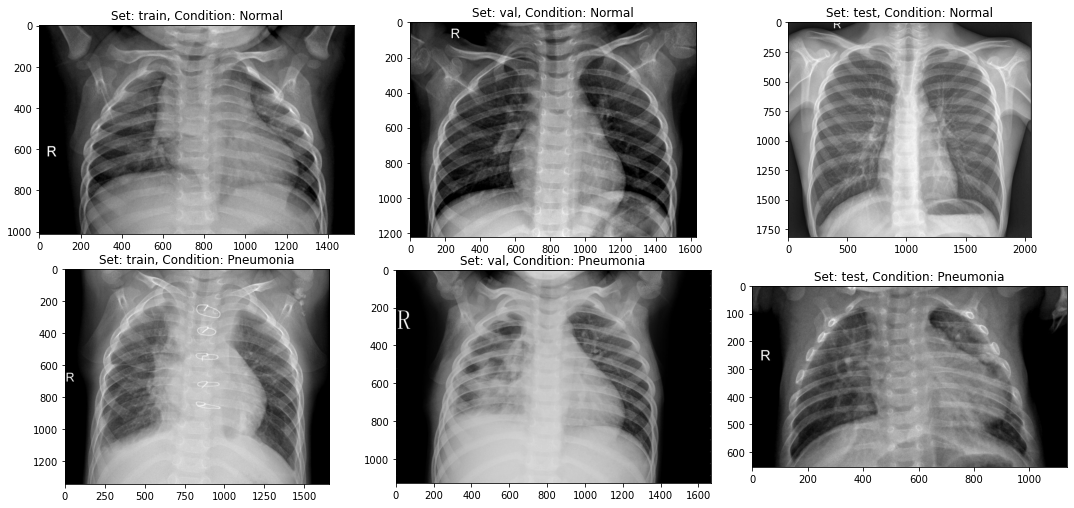

In [54]:
#input_path = '../input/chest_xray/chest_xray/'
input_path = 'chest_xray_dataset/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()



for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))


In [53]:
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 8, pneumonia images: 8
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 8, pneumonia images: 8


In [73]:
input_path = 'chest_xray_dataset/'

def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [63]:
#print(os.listdir("chest_xray_dataset/train/NORMAL/*"))

#Resize images to
SIZE = 128

#Capture images and labels into arrays.
#Start by creating empty lists.
train_images = []
train_labels = [] 
#for directory_path in glob.glob("cell_images/train/*"):
for directory_path in glob.glob("chest_xray_dataset/train"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        print(img_path)
        img = cv2.imread(img_path, 0) #Reading color images
        img = cv2.resize(img, (SIZE, SIZE)) #Resize images
        train_images.append(img)
        train_labels.append(label)
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

#Do exactly the same for test/validation images
# test
test_images = []
test_labels = []
#for directory_path in glob.glob("cell_images/test/*"): 
for directory_path in glob.glob("chest_xray_dataset/test"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (SIZE, SIZE))
        test_images.append(img)
        test_labels.append(fruit_label)
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)

#Encode labels from text (folder names) to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
#If you only have one dataset then split here
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# Normalize pixel values to between 0 and 1
#x_train, x_test = x_train / 255.0, x_test / 255.0

chest_xray_dataset/train


In [31]:
#GLCM feature extractor
def feature_extractor(dataset):
    image_dataset = pd.DataFrame()
    for image in range(dataset.shape[0]):  #iterate through each file 
        
        df = pd.DataFrame()                #Temporary data frame to capture information for each loop, Reset dataframe to blank after each loop.
        img = dataset[image, :,:]

        #GLCM = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        GLCM = greycomatrix(img, [1], [0])       
        GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        df['Energy'] = GLCM_Energy
        GLCM_corr = greycoprops(GLCM, 'correlation')[0]
        df['Corr'] = GLCM_corr       
        GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
        df['Diss_sim'] = GLCM_diss       
        GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
        df['Homogen'] = GLCM_hom       
        GLCM_contr = greycoprops(GLCM, 'contrast')[0]
        df['Contrast'] = GLCM_contr


        GLCM2 = greycomatrix(img, [3], [0])       
        GLCM_Energy2 = greycoprops(GLCM2, 'energy')[0]
        df['Energy2'] = GLCM_Energy2
        GLCM_corr2 = greycoprops(GLCM2, 'correlation')[0]
        df['Corr2'] = GLCM_corr2       
        GLCM_diss2 = greycoprops(GLCM2, 'dissimilarity')[0]
        df['Diss_sim2'] = GLCM_diss2       
        GLCM_hom2 = greycoprops(GLCM2, 'homogeneity')[0]
        df['Homogen2'] = GLCM_hom2       
        GLCM_contr2 = greycoprops(GLCM2, 'contrast')[0]
        df['Contrast2'] = GLCM_contr2

        GLCM3 = greycomatrix(img, [5], [0])       
        GLCM_Energy3 = greycoprops(GLCM3, 'energy')[0]
        df['Energy3'] = GLCM_Energy3
        GLCM_corr3 = greycoprops(GLCM3, 'correlation')[0]
        df['Corr3'] = GLCM_corr3       
        GLCM_diss3 = greycoprops(GLCM3, 'dissimilarity')[0]
        df['Diss_sim3'] = GLCM_diss3       
        GLCM_hom3 = greycoprops(GLCM3, 'homogeneity')[0]
        df['Homogen3'] = GLCM_hom3       
        GLCM_contr3 = greycoprops(GLCM3, 'contrast')[0]
        df['Contrast3'] = GLCM_contr3

        GLCM4 = greycomatrix(img, [0], [np.pi/4])       
        GLCM_Energy4 = greycoprops(GLCM4, 'energy')[0]
        df['Energy4'] = GLCM_Energy4
        GLCM_corr4 = greycoprops(GLCM4, 'correlation')[0]
        df['Corr4'] = GLCM_corr4       
        GLCM_diss4 = greycoprops(GLCM4, 'dissimilarity')[0]
        df['Diss_sim4'] = GLCM_diss4       
        GLCM_hom4 = greycoprops(GLCM4, 'homogeneity')[0]
        df['Homogen4'] = GLCM_hom4       
        GLCM_contr4 = greycoprops(GLCM4, 'contrast')[0]
        df['Contrast4'] = GLCM_contr4
        
        GLCM5 = greycomatrix(img, [0], [np.pi/2])       
        GLCM_Energy5 = greycoprops(GLCM5, 'energy')[0]
        df['Energy5'] = GLCM_Energy5
        GLCM_corr5 = greycoprops(GLCM5, 'correlation')[0]
        df['Corr5'] = GLCM_corr5       
        GLCM_diss5 = greycoprops(GLCM5, 'dissimilarity')[0]
        df['Diss_sim5'] = GLCM_diss5       
        GLCM_hom5 = greycoprops(GLCM5, 'homogeneity')[0]
        df['Homogen5'] = GLCM_hom5       
        GLCM_contr5 = greycoprops(GLCM5, 'contrast')[0]
        df['Contrast5'] = GLCM_contr5
        
        #Adding more filters as needed
        entropy = shannon_entropy(img)
        df['Entropy'] = entropy

        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset

**Extract features from training images**

In [65]:
#process_data(32, 128):
image_features = process_data(32, 128)
#image_features = feature_extractor(x_train)
X_for_ML =image_features

Found 14 images belonging to 3 classes.
Found 16 images belonging to 3 classes.


**Reshape to a vector for SVM training**



In [72]:
print(image_features)
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
X_for_ML = np.reshape(image_features, (x_train.shape[0], -1))


(<keras.preprocessing.image.DirectoryIterator object at 0x7ff56dc6dc90>, <keras.preprocessing.image.DirectoryIterator object at 0x7ff56dc41fd0>, array([[[[0.14901961, 0.14901961, 0.14901961],
         [0.11372549, 0.11372549, 0.11372549],
         [0.10196079, 0.10196079, 0.10196079],
         ...,
         [0.1254902 , 0.1254902 , 0.1254902 ],
         [0.13333334, 0.13333334, 0.13333334],
         [0.15686275, 0.15686275, 0.15686275]],

        [[0.10588235, 0.10588235, 0.10588235],
         [0.25490198, 0.25490198, 0.25490198],
         [0.41568628, 0.41568628, 0.41568628],
         ...,
         [0.10980392, 0.10980392, 0.10980392],
         [0.13725491, 0.13725491, 0.13725491],
         [0.15294118, 0.15294118, 0.15294118]],

        [[0.33333334, 0.33333334, 0.33333334],
         [0.5137255 , 0.5137255 , 0.5137255 ],
         [0.49019608, 0.49019608, 0.49019608],
         ...,
         [0.24705882, 0.24705882, 0.24705882],
         [0.10196079, 0.10196079, 0.10196079],
         [

'n_features = image_features.shape[1]\nimage_features = np.expand_dims(image_features, axis=0)\nX_for_ML = np.reshape(image_features, (x_train.shape[0], -1))'

**Classifier : Support Vector Machines** 

In [74]:
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(X_for_ML, y_train)